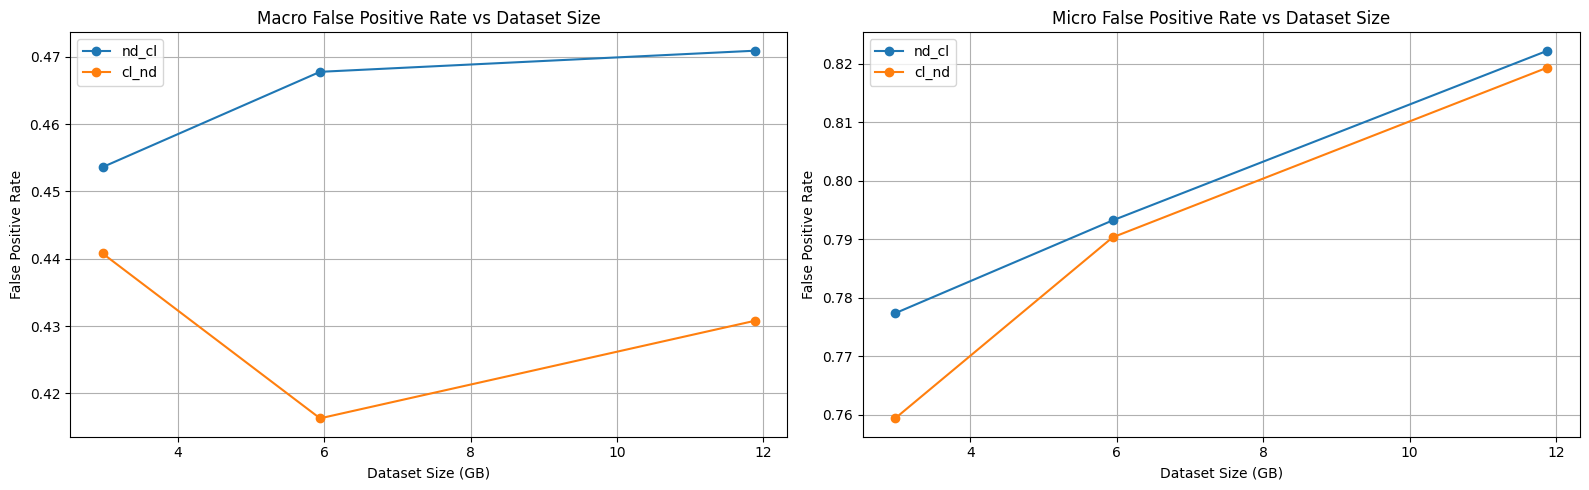

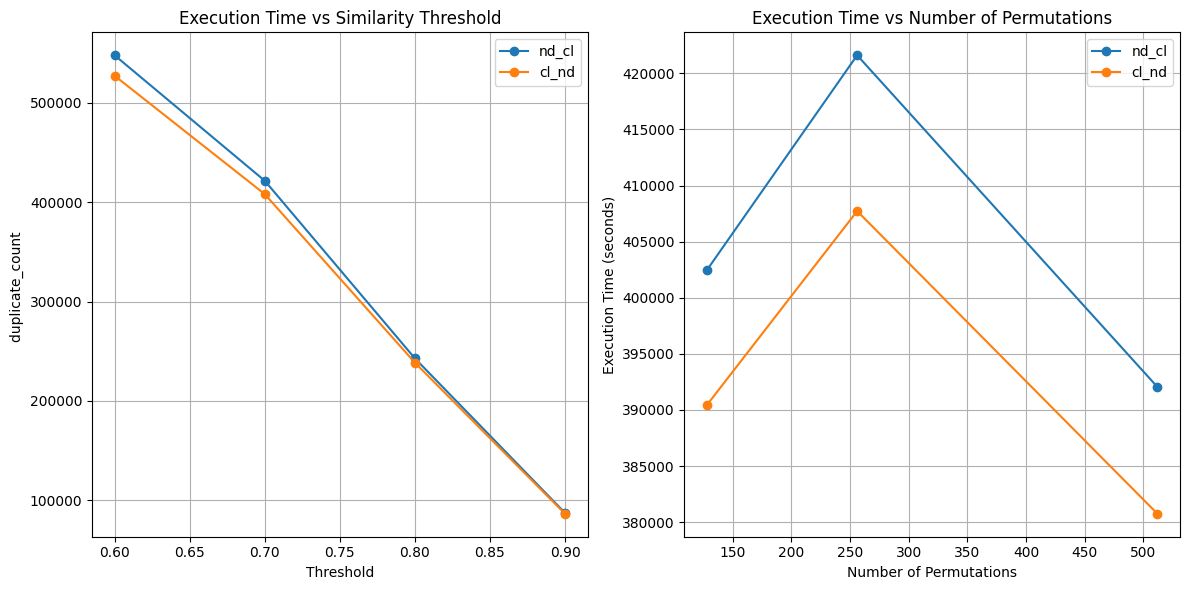

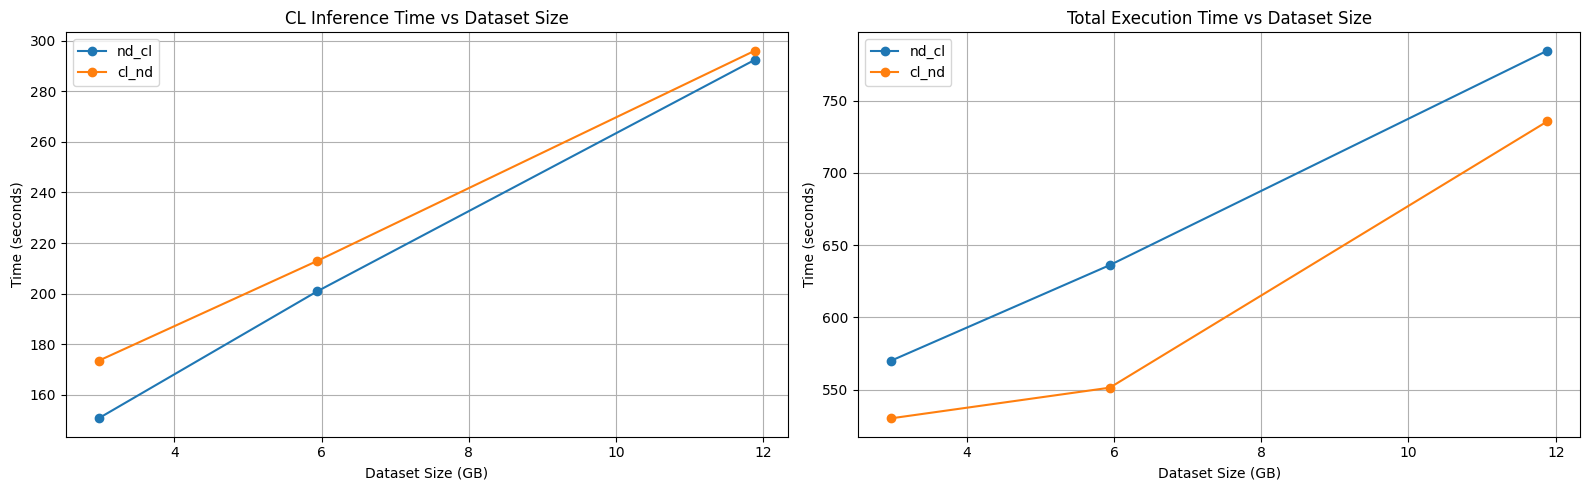

|    |   duplicate_count | implementation   |   threshold |   num_perm |   execution_time |   total_size_gb |   cl_train_time_sec |   cl_inference_time_sec |   cl_stage2_time_sec | exp_name                                  |
|---:|------------------:|:-----------------|------------:|-----------:|-----------------:|----------------:|--------------------:|------------------------:|---------------------:|:------------------------------------------|
|  1 |             76548 | nd_cl            |         0.7 |        256 |          570.027 |         2.97242 |             1439.61 |                 150.74  |              336.513 | nd_cl_datasize_files10_thresh0.7_perm256  |
|  2 |             73958 | cl_nd            |         0.7 |        256 |          530.176 |         2.97242 |             1414.37 |                 173.494 |              344.237 | cl_nd_datasize_files10_thresh0.7_perm256  |
|  3 |            180792 | nd_cl            |         0.7 |        256 |          636.151 |         

In [5]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd

# Load environment variables from .env file
load_dotenv()

# Get POSTGRES_ADDRESS from .env file
POSTGRES_ADDRESS = os.getenv("POSTGRES_ADDRESS")


# Create engine with the address
engine = create_engine(POSTGRES_ADDRESS)




def get_fp(row):
    if row["implementation"].startswith("nd"):
        ro_met =  row["metrics"]["nd_metrics"]
        row["fp_micro"] = ro_met["false_positive_count"]/ro_met["total_pairs"]
        row["fp_macro"] = ro_met["false_positive_rate"]
    else:
        ro_met =  row["metrics"]["cl_metrics"][-1]
        row["fp_micro"] =  ro_met["total_false_positive_count"]/ro_met["total_total_pairs"]
        row["fp_macro"] = ro_met["total_false_positive_rate"]
        
    return row
        

def get_sim_df():
    sim_df = pd.read_sql_query("SELECT * FROM benchmark_runs_v2", engine)
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Set width to 1000 characters
    pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines
    sim_df =  sim_df.query("id>1")
    
    sim_df = sim_df.apply(get_fp, axis=1)
    sim_df = sim_df.drop(columns=["ngram_size", "min_ngram_size", "num_perm", "limit_files", "num_nodes", "record_count", "duplicate_count", "input_file", "timestamp", "id"])
    sim_df = sim_df.assign(exp_name=sim_df.output_dir.str.split("/").str[-1]).drop(columns=["output_dir"])
    sim_df = sim_df.iloc[:7]
    return sim_df


def plot_fp_macro_vs_size():
    sim_df = get_sim_df()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))


    for wf in ['nd_cl', 'cl_nd']:
        subset = sim_df[(sim_df['implementation'] == wf) & (sim_df['threshold'] == 0.7)]
        subset = subset.sort_values('total_size_gb')
        ax1.plot(subset['total_size_gb'], subset['fp_macro'], marker='o', label=f'{wf}')

    ax1.set_title('Macro False Positive Rate vs Dataset Size')
    ax1.set_xlabel('Dataset Size (GB)')
    ax1.set_ylabel('False Positive Rate')
    ax1.grid(True)
    ax1.legend()

    for wf in ['nd_cl', 'cl_nd']:
        subset = sim_df[(sim_df['implementation'] == wf) & (sim_df['threshold'] == 0.7)]
        subset = subset.sort_values('total_size_gb')
        ax2.plot(subset['total_size_gb'], subset['fp_micro'], marker='o', label=f'{wf}')

    ax2.set_title('Micro False Positive Rate vs Dataset Size')
    ax2.set_xlabel('Dataset Size (GB)')
    ax2.set_ylabel('False Positive Rate')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('fp_rates_vs_dataset_size.pdf')
    plt.show()


def get_time_df():
    time_df = pd.read_sql_query("SELECT * FROM benchmark_runs", engine)
    # Set pandas display options to make tables wider
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Set width to 1000 characters
    pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines

    
    time_df = time_df.assign(exp_name=time_df.output_dir.str.split("/").str[-1]).drop(columns=["output_dir"])
    time_df = time_df.drop(columns=["ngram_size", "min_ngram_size",  "record_count","timestamp", "id","config_details_json","config_file_path","limit_files","num_nodes","input_file","nd_time_sec","notes"]).iloc[1:-4]
    # Drop columns that contain NaN or 0 values
    time_df = time_df.loc[:, ~(time_df.isna().any() | (time_df == 0).all())]
    return time_df


def plot_execution_times():
    """
    Create plots comparing execution times for different parameters between the two implementations.
    """
    time_df = get_time_df()
    
    # Create a figure with three subplots (dataset size, threshold, num_perm)
    fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 2. Plot execution time vs threshold
    threshold_data = time_df[time_df['exp_name'].str.contains('threshold')]
    
    for wf in ['nd_cl', 'cl_nd']:
        subset = threshold_data[threshold_data['implementation'] == wf]
        subset = subset.sort_values('threshold')
        ax2.plot(subset['threshold'], subset['duplicate_count'], marker='o', label=f'{wf}')
    
    ax2.set_title('Execution Time vs Similarity Threshold')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('duplicate_count ')
    ax2.grid(True)
    ax2.legend()
    
    # 3. Plot execution time vs num_perm
    perm_data = time_df[time_df['exp_name'].str.contains('numperm')]
    
    for wf in ['nd_cl', 'cl_nd']:
        subset = perm_data[perm_data['implementation'] == wf]
        subset = subset.sort_values('num_perm')
        ax3.plot(subset['num_perm'], subset['duplicate_count'], marker='o', label=f'{wf}')
    
    ax3.set_title('Execution Time vs Number of Permutations')
    ax3.set_xlabel('Number of Permutations')
    ax3.set_ylabel('Execution Time (seconds)')
    ax3.grid(True)
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig('execution_times_comparison.pdf')
    plt.show()


def plot_component_times():
    """
    Create plots comparing component times (CL train, inference, stage2) for both implementations.
    """
    time_df = get_time_df()
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Extract CL component times
    cl_components = [
        ('cl_inference_time_sec', 'CL Inference Time', 0, 0),
        ('execution_time', 'Total Execution Time', 0, 1)
    ]
    
    # Categorize by dataset size
    size_data = time_df[time_df['exp_name'].str.contains('datasize')]
    
    # Plot each component
    for col, title, row, col_idx in cl_components:
        ax = axes[col_idx]
        
        for wf in ['nd_cl', 'cl_nd']:
            subset = size_data[size_data['implementation'] == wf]
            subset = subset.sort_values('total_size_gb')
            ax.plot(subset['total_size_gb'], subset[col], marker='o', label=f'{wf}')
        
        ax.set_title(f'{title} vs Dataset Size')
        ax.set_xlabel('Dataset Size (GB)')
        ax.set_ylabel('Time (seconds)')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('component_times_comparison.pdf')
    plt.show()


# Total Execution Time vs Dataset Size
import fire


def main(mode="both"):
    if mode == "both":
        plot_fp_macro_vs_size()
        time_df = get_time_df()
        plot_execution_times()
        plot_component_times()
        print(time_df.to_markdown())
    elif mode == "fp":
        plot_fp_macro_vs_size()
    elif mode == "time":
        time_df = get_time_df()
        plot_execution_times()
        plot_component_times()
        print(time_df.to_markdown())
    else:
        raise ValueError(f"Invalid mode: {mode}")

main()

